<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT19/blob/maxbergmark/Lab-5/maxbergmark_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 5: Ordinary Differential equations**
**Max Bergmark**

# **Abstract**

In this lab, I investigate different iteration methods for ordinary differential equations, and use them to approximate the n-body problem. 

#**About the code**

I am the author of the code in its entirety.

# **Set up environment**

In [0]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

In this lab, I have investigated time stepping solutions for ordinary differential equations. I have applied Explicit Euler, Runge-Kutta 2 and Runge-Kutta 4, and analyzed convergence rates for different differential equations. 

# **Methods**

In [0]:
def euler_forward(f, u_0, T, dt):
    t = [0]
    u = [u_0]
    while t[-1] < T:
        du = f(u[-1], t[-1])
        u.append(u[-1] + du*dt)
        t.append(t[-1] + dt)
    return np.array(t), np.array(u)

def rk_2(f, u_0, T, dt):
    t = [0]
    u = [u_0]
    du = f(u[-1], t[-1])
    while t[-1] < T:
        new_du = f(u[-1] + du*dt, t[-1] + dt)
        u.append(u[-1] + .5*(du + new_du)*dt)
        t.append(t[-1] + dt)
        du = new_du
    return np.array(t), np.array(u)

def rk_4(f, u_0, T, dt):
    t = [0]
    u = [u_0]
    while t[-1] < T:
        k1 = dt * f(u[-1], t[-1])
        k2 = dt * f(u[-1] + k1/2, t[-1] + dt/2)
        k3 = dt * f(u[-1] + k2/2, t[-1] + dt/2)
        k4 = dt * f(u[-1] + k3, t[-1] + dt)
        u.append(u[-1] + 1/6*(k1 + 2*k2 + 2*k3 + k4))
        t.append(t[-1] + dt)
    return np.array(t), np.array(u)

## 1: Time stepping for scalar initial value problem du/dt = f(u,t)

For this problem, I chose the simple equation $\frac{du}{dt} = 1.23u$, which has the solution $u(t) = c * e^{1.23t}$. Since this function is convex for $c > 0$, this means that Explicit Euler will underestimate the value of the function. 

## 2: Time stepping for system of initial value problems du/dt = f(u,t)

For this problem, I chose to investigate a 2D system, since it was easier to verify correctness of my results. However, the solutions implemented are not dependent on the system being limited to 2D.

I chose the system $\frac{d\vec{u}}{dt} = \begin{bmatrix} 3 & 2 \\ 2 & 3\end{bmatrix} \cdot \vec{u}$, which has eigenvalues $1$ and $5$, and corresponding eigenvectors $\begin{bmatrix} -1 \\ 1\end{bmatrix}$ and $\begin{bmatrix} 1 \\ 1 \end{bmatrix}$.

## 3: Choose an ODE model from chapter 15 "Systems of initial value problems" in the lecture notes

For the bonus, I chose the n-body problem. To solve this problem using the models created in this lab, we need to split it into $2n$ equations, since the n-body-problem has a second derivative in the equation $m\ddot{x} = F$. Since we know that $v = \dot{x}$ and $\ddot{x} = \dot{v}$, we can easily separate the system to get first order equations. 

Let $u = \begin{bmatrix} v_1 \\ \vdots \\ v_n \\ x_1  \\ \vdots \\ x_n \end{bmatrix}$, and $\frac{du}{dt} = \begin{bmatrix} \frac{F_1}{m_1} \\ \vdots \\ \frac{F_n}{m_n} \\ v_1  \\ \vdots \\ v_n \end{bmatrix}$ along with Newton's gravitational formula: $F_{ij} = \frac{Gm_im_j}{r_{ij}^2}$, where $r$ is the distance between $x_i$ and $x_j$.

Using this, the implementation can be seen below. I included the masses in the function to be able to use the same functions for solving the system as before. One optimization used is to only calculate half of the forces, since the other halves are just the reactive forces. I also defaulted to calculating accelerations directly rather than converting them later. 

In [0]:
def f_n_body(u, t):
    M = np.array([
        1.989e30, 
        5.972e24, 
        7.34767309e22, 
        3.825e23,
        4.867e24
    ])
    du = np.zeros_like(u)
    n = u.shape[0]//2 
    G = 6.67e-11
    du[n:,:] = u[:n,:]
    for i in range(n):
        for j in range(i+1, n):
            diff = u[n+j,:] - u[n+i,:]
            r = np.linalg.norm(diff)
            direction = diff / r
            # apply acceleration to pair of bodies
            du[i,:] += direction * G * M[j] / r**2
            du[j,:] -= direction * G * M[i] / r**2

    return du

# **Results**

## 1: Time stepping for scalar initial value problem du/dt = f(u,t)

Since the equations we are studying have exponential solutions with positive exponents, the function values will get large very quickly. Explicit Euler is not well suited for approximating these solutions, but we can see below that the approximations with higher convergence rate perform very well. Runge-Kutta-4 is only limited by the float precision when the time step is small, which explains the jagged line at the bottom. 

The convergence rates are also as expected. They should be 1, 2,  and 4, which is very close to the found experimental values. 

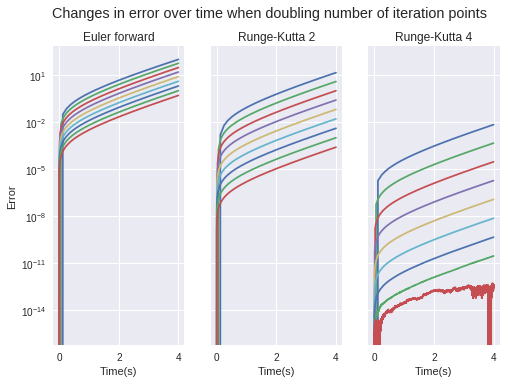

In [46]:
def test_error_over_time_1D():
    f = lambda u, t: 1.23*u
    sol = lambda t: 2.34 * np.exp(1.23*t)
    u_0 = 2.34
    fig, ax = plt.subplots(1, 3, sharey = True)
    for i in range(3, 12):
        t, u = euler_forward(f, u_0, 4, 2**-i)
        err = abs(u - sol(t))
        ax[0].semilogy(t, err, '-')
        t, u = rk_2(f, u_0, 4, 2**-i)
        err = abs(u - sol(t))
        ax[1].semilogy(t, err, '-')
        t, u = rk_4(f, u_0, 4, 2**-i)
        err = abs(u - sol(t))
        ax[2].semilogy(t, err, '-')
    plt.suptitle("Changes in error over time when doubling number of iteration points")
    ax[0].set_title("Euler forward")
    ax[0].set_xlabel("Time(s)")
    ax[1].set_title("Runge-Kutta 2")
    ax[1].set_xlabel("Time(s)")
    ax[2].set_title("Runge-Kutta 4")
    ax[2].set_xlabel("Time(s)")
    ax[0].set_ylabel("Error")
    plt.show()

test_error_over_time_1D()

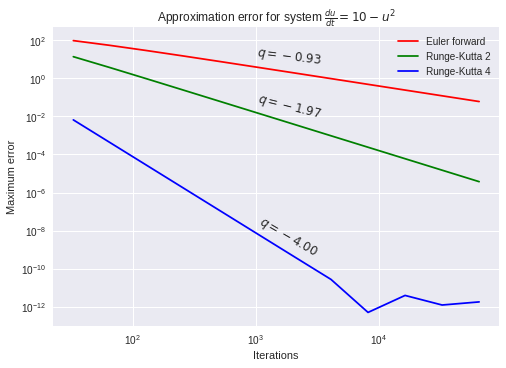

In [47]:
def test_convergence_rate_1D():
    plt.figure()
    f = lambda u, t: 1.23*u
    sol = lambda t: 2.34 * np.exp(1.23*t)
    u_0 = 2.34

    err_euler = []
    err_rk2 = []
    err_rk4 = []
    iters = []
    for i in range(3, 15):
        t, u = euler_forward(f, u_0, 4, 2**-i)
        err_euler.append(np.abs(u - sol(t)).max())
        t, u = rk_2(f, u_0, 4, 2**-i)
        err_rk2.append(np.abs(u - sol(t)).max())
        t, u = rk_4(f, u_0, 4, 2**-i)
        err_rk4.append(np.abs(u - sol(t)).max())
        iters.append(len(t))

    plt.loglog(iters, err_euler, 'r', label = "Euler forward")
    plt.loglog(iters, err_rk2, 'g', label = "Runge-Kutta 2")
    plt.loglog(iters, err_rk4, 'b', label = "Runge-Kutta 4")
    c_euler = (np.log(err_euler[5]) - np.log(err_euler[0]))/(np.log(iters[5]) - np.log(iters[0]))
    c_rk2 = (np.log(err_rk2[5]) - np.log(err_rk2[0]))/(np.log(iters[5]) - np.log(iters[0]))
    c_rk4 = (np.log(err_rk4[5]) - np.log(err_rk4[0]))/(np.log(iters[5]) - np.log(iters[0]))
    plt.text(1*10**3, 1.5*10**1, "$q = %.2f$" % c_euler, rotation = -7)
    plt.text(1*10**3, 6*10**-2, "$q = %.2f$" % c_rk2, rotation = -14)
    plt.text(1*10**3, 2*10**-8, "$q = %.2f$" % c_rk4, rotation = -30)
    plt.xlabel("Iterations")
    plt.ylabel("Maximum error")
    plt.title("Approximation error for system $\\frac{du}{dt} = 10 - u^2$")
    plt.legend()
    plt.show()
    
test_convergence_rate_1D()

## 2: Time stepping for system of initial value problems du/dt = f(u,t)

The solution for this is very similar to the 1D case. However, due to my choice of coefficients, the values get very large very fast. To be able to visualize the convergence better, I also included the relative error, which is obtained by dividing the error by the approximation value. 

For this choice of equation, the convergence rate graphs are not as exact as for the 1D case, but we are still able to verify that the convergence rates are as expected. 

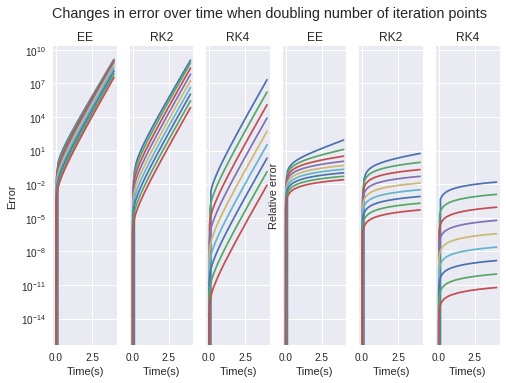

In [49]:
def test_error_over_time_2D():
    f = lambda u, t: np.dot(np.array([[3, 2], [2, 3]]), u)
    sol = lambda t: np.array([(2*1 * np.exp(5*t) - 1*1 * np.exp(t)), (2*1 * np.exp(5*t) + 1*1 * np.exp(t))])
    u_0 = np.array([1, 3])
    fig, ax = plt.subplots(1, 6, sharey = True)
    for i in range(3, 12):
        t, u = euler_forward(f, u_0, 4, 2**-i)
        err = np.linalg.norm(u - sol(t).T, axis = 1)
        ax[0].semilogy(t, err, '-')
        ax[3].semilogy(t, err/np.linalg.norm(u, axis = 1), '-')
        t, u = rk_2(f, u_0, 4, 2**-i)
        err = np.linalg.norm(u - sol(t).T, axis = 1)
        ax[1].semilogy(t, err, '-')
        ax[4].semilogy(t, err/np.linalg.norm(u, axis = 1), '-')
        t, u = rk_4(f, u_0, 4, 2**-i)
        err = np.linalg.norm(u - sol(t).T, axis = 1)
        ax[2].semilogy(t, err, '-')
        ax[5].semilogy(t, err/np.linalg.norm(u, axis = 1), '-')
    plt.suptitle("Changes in error over time when doubling number of iteration points")
    ax[0].set_title("EE")
    ax[3].set_title("EE")
    ax[1].set_title("RK2")
    ax[4].set_title("RK2")
    ax[2].set_title("RK4")
    ax[5].set_title("RK4")
    for i in range(6):
        ax[i].set_xlabel("Time(s)")
    ax[0].set_ylabel("Error")
    ax[3].set_ylabel("Relative error")
    plt.show()
    
test_error_over_time_2D()

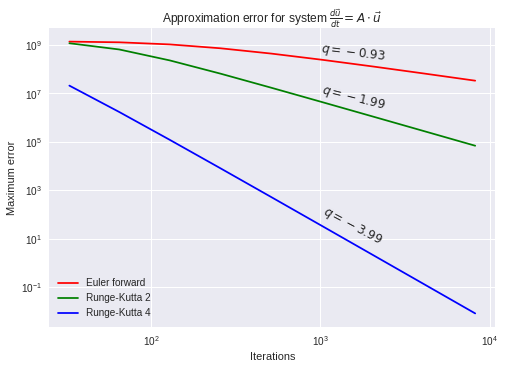

In [50]:
def test_convergence_rate_2D():
    plt.figure()
    f = lambda u, t: np.dot(np.array([[3, 2], [2, 3]]), u)
    sol = lambda t: np.array([(2*1 * np.exp(5*t) - 1*1 * np.exp(t)), (2*1 * np.exp(5*t) + 1*1 * np.exp(t))])
    u_0 = np.array([1, 3])

    err_euler = []
    err_rk2 = []
    err_rk4 = []
    iters = []
    for i in range(3, 12):
        t, u = euler_forward(f, u_0, 4, 2**-i)
        err_euler.append(np.linalg.norm(u - sol(t).T, axis = 1).max())
        t, u = rk_2(f, u_0, 4, 2**-i)
        err_rk2.append(np.linalg.norm(u - sol(t).T, axis = 1).max())
        t, u = rk_4(f, u_0, 4, 2**-i)
        err_rk4.append(np.linalg.norm(u - sol(t).T, axis = 1).max())
        iters.append(len(t))

    plt.loglog(iters, err_euler, 'r', label = "Euler forward")
    plt.loglog(iters, err_rk2, 'g', label = "Runge-Kutta 2")
    plt.loglog(iters, err_rk4, 'b', label = "Runge-Kutta 4")
    c_euler = (np.log(err_euler[-1]) - np.log(err_euler[-5]))/(np.log(iters[-1]) - np.log(iters[-5]))
    c_rk2 = (np.log(err_rk2[-1]) - np.log(err_rk2[-5]))/(np.log(iters[-1]) - np.log(iters[-5]))
    c_rk4 = (np.log(err_rk4[-1]) - np.log(err_rk4[-5]))/(np.log(iters[-1]) - np.log(iters[-5]))
    plt.text(1*10**3, 5*10**8, "$q = %.2f$" % c_euler, rotation = -7)
    plt.text(1*10**3, 1*10**7, "$q = %.2f$" % c_rk2, rotation = -14)
    plt.text(1*10**3, 1*10**2, "$q = %.2f$" % c_rk4, rotation = -28)
    plt.xlabel("Iterations")
    plt.ylabel("Maximum error")
    plt.title(r"Approximation error for system $\frac{d\vec{u}}{dt} = A \cdot \vec{u}$")
    plt.legend()
    plt.show()
    
test_convergence_rate_2D()

## 3: Choose an ODE model from chapter 15 "Systems of initial value problems" in the lecture notes

To test the accuracy of my implementation, I decided to use it to calculate the length of the year on Earth. I found the masses, orbital speed, and distance from the sun for 5 celestial bodies in our solar system. I set that as the initial condition of the iteration, and set the iteration limit to $86400*365$ seconds, the number of seconds in one year. If the system is working as intended, earth should have completed one revolution around the sun. I set the time step to $86400$ seconds, which is one day. It could have been set finer, but choosing this value lets us visualize the increase of energy in the Explicit Euler iteration. 

In the graph generated below, Runge-Kutta 4 is in green, Runge-Kutta 2 is in red, and Explicit Euler is in blue. It is clear that the Explicit Euler iteration is not stable, but the two Runge-Kutta iterations look very similar, and we can also see that the outermost planet (which is Earth) has almost finished its first revolution around the sun. From this, it seems that our implementation is correct!

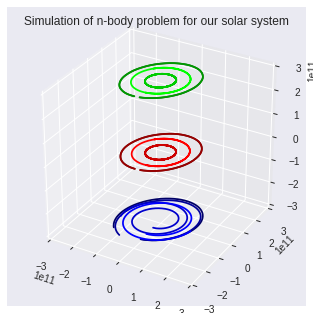

In [51]:
def n_body_problem():
    v0 = np.array([
        [0, 0, 0], # sun
        [1.08e5/3.6*np.cos(7.155*np.pi/180), 0, 1.08e5/3.6*np.sin(7.155*np.pi/180)], # earth
        [1.08e5/3.6*np.cos(7.155*np.pi/180) + 3.683e3/3.6, 0, 1.08e5/3.6*np.sin(7.155*np.pi/180)], # moon
        [1.70505e5/3.6*np.cos(3.38*np.pi/180), 0, 1.70505e5/3.6*np.sin(3.38*np.pi/180)], #mercury
        [1.26077e5/3.6*np.cos(3.86*np.pi/180), 0, 1.26077e5/3.6*np.sin(3.86*np.pi/180)] # venus
    ])
    x0 = np.array([
        [0, 0, 0],
        [0, -1.496e11, 0],
        [0, -1.496e11 - 3.844e8, 0],
        [0, -5.791e10, 0],
        [0, -1.082e11, 0]
    ])
    n = x0.shape[0]
    u0 = np.zeros((2*n, 3))
    u0[:n,:] = v0
    u0[n:,:] = x0

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    t_e, u_e = euler_forward(f_n_body, u0.copy(), 86400*365*1, 86400)
    t_2, u_2 = rk_2(f_n_body, u0.copy(), 86400*365*1, 86400)
    t_4, u_4 = rk_4(f_n_body, u0.copy(), 86400*365*1, 86400)
    for i in range(n):
        x_e, y_e, z_e = u_e[:,n+i,:].T
        x_2, y_2, z_2 = u_2[:,n+i,:].T
        x_4, y_4, z_4 = u_4[:,n+i,:].T
        ax.plot(x_e, y_e, z_e - 3e11, c = (0, 0, (i+1)/n))
        ax.plot(x_2, y_2, z_2, c = ((i+1)/n, 0, 0))
        ax.plot(x_4, y_4, z_4 + 3e11, c = (0, (i+1)/n, 0))
    ax.set_xlim([-3e11, 3e11])
    ax.set_ylim([-3e11, 3e11])
    ax.set_zlim([-3e11, 3e11])
    ax.set_aspect('equal')
    plt.title("Simulation of n-body problem for our solar system")
    plt.show()

n_body_problem()

# **Discussion**

The results were as expected. However, for exponential solutions, looking at the relative error could give a better understanding compared to looking at the absolute error. I initially though that my implementation was incorrect, since my error was larger that $10^6$. However, once I realized that this was an error of $<1\%$, I understood that my implementation was correct.